In [1]:
import os

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import cv2

import albumentations as A

import albumentations.pytorch

import random
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from tqdm import tqdm, tqdm_notebook

import pickle
from pathlib import Path
import PIL

import GPUtil
from GPUtil import showUtilization as gpu_usage

import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from jupyterthemes import jtplot
import warnings

#import functools

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

#torch.backends.cudnn.benchmark = True
#torch.backends.cudnn.enabled = True

In [3]:
def set_random(n):
    random.seed(n)
    np.random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.backends.cudnn.deterministic = True
    
set_random(42)

# Load data

In [4]:
cell_df = pd.read_csv('./sartorius-cell-instance-segmentation/train.csv')
cell_df.info()
cell_df.sample(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


id                                         annotation  width  \
65518  de504eaa5349  252178 6 252881 8 253585 9 254288 10 254992 11...    704   
48139  a76fe4d00355  112202 6 112905 10 113608 11 114314 9 115018 9...    704   
37042  836e5872684a  268741 3 269440 10 270138 18 270839 23 271544 ...    704   
60537  d09291445961  125348 8 126050 11 126753 13 127457 15 128162 ...    704   

       height cell_type plate_time sample_date  \
65518     520    shsy5y  11h30m00s  2019-06-15   
48139     520    shsy5y  11h30m00s  2019-06-14   
37042     520    shsy5y  11h30m00s  2019-06-14   
60537     520     astro  09h00m00s  2020-09-14   

                                sample_id elapsed_timedelta  
65518  shsy5y[diff]_D12-1_Vessel-714_Ph_2   0 days 11:30:00  
48139  shsy5y[diff]_E10-2_Vessel-714_Ph_3   0 days 11:30:00  
37042  shsy5y[diff]_D12-4_Vessel-714_Ph_4   0 days 11:30:00  
60537  astros[cereb]_F8-2_Vessel-361_Ph_4   0 days 09:00:00

In [5]:
TRAIN_DIR = Path('./sartorius-cell-instance-segmentation/train/')
TEST_DIR = Path('./sartorius-cell-instance-segmentation/test/')

In [6]:
train_files = sorted(list(TRAIN_DIR.rglob('*.png')))
test_files = sorted(list(TEST_DIR.rglob('*.png')))

In [7]:
print(f'Number of pictures in train dir: {len(train_files)} pcs')
print()
print(f'Number of pictures in test dir: {len(test_files)} pcs')

Number of pictures in train dir: 606 pcs

Number of pictures in test dir: 3 pcs


# Visualize the data

Create functions to make a mask based on annotations given in train.csv file

In [8]:
def rle_decode(mask_rle,shape,color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    if colors = 1, then:
    Returns numpy array, 1 - mask, 0 - background
    '''
    
    s = mask_rle.split()
    # get starting pixel and cells's length
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    start -=1
    # Ending pixels
    ends = start + length
    img = np.zeros((shape[0] * shape[1], shape [2]), dtype=np.float32)
    for lo, hi in zip (start, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [9]:
def build_mask(labels, input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width,3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height,width, 1))
    mask = mask.clip(0,1)
    return mask

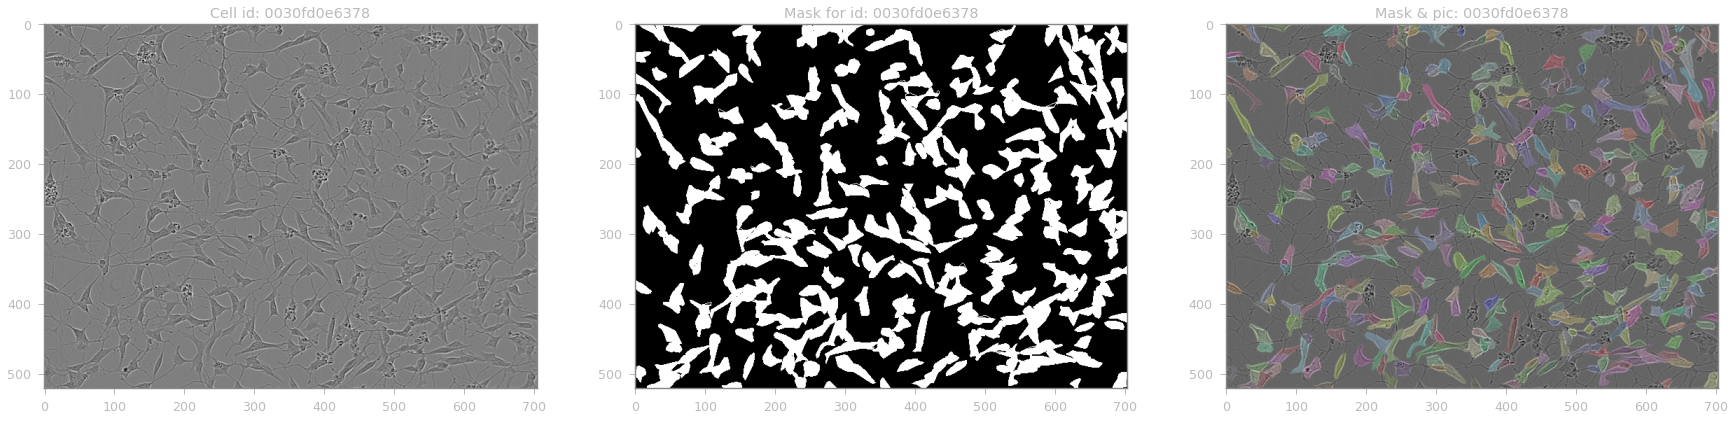

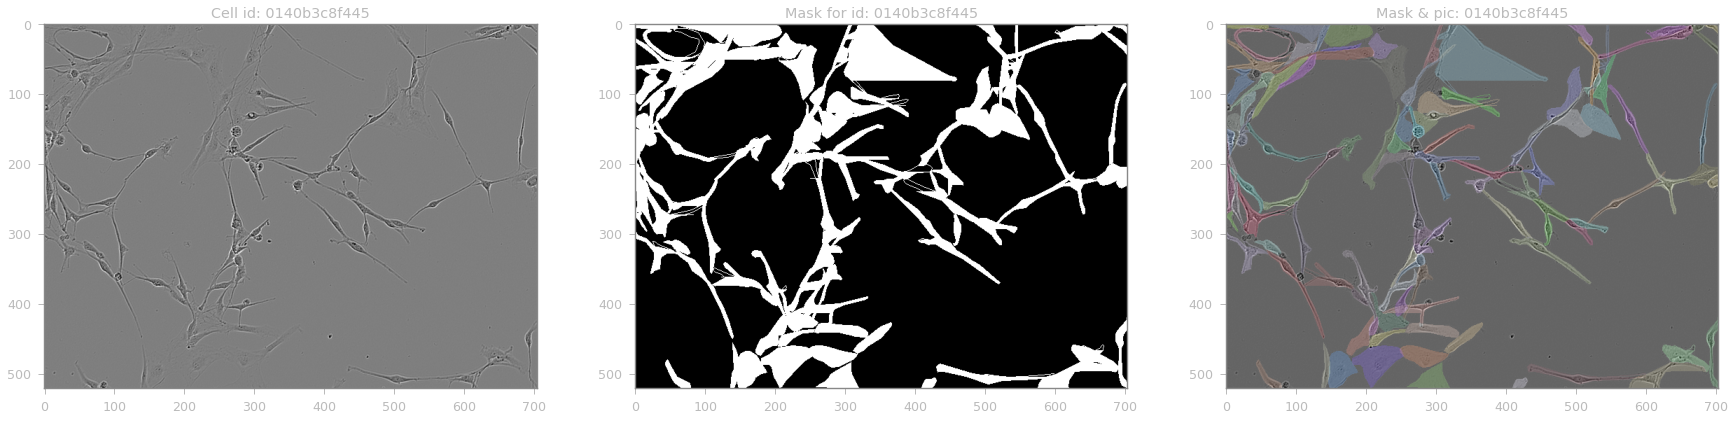

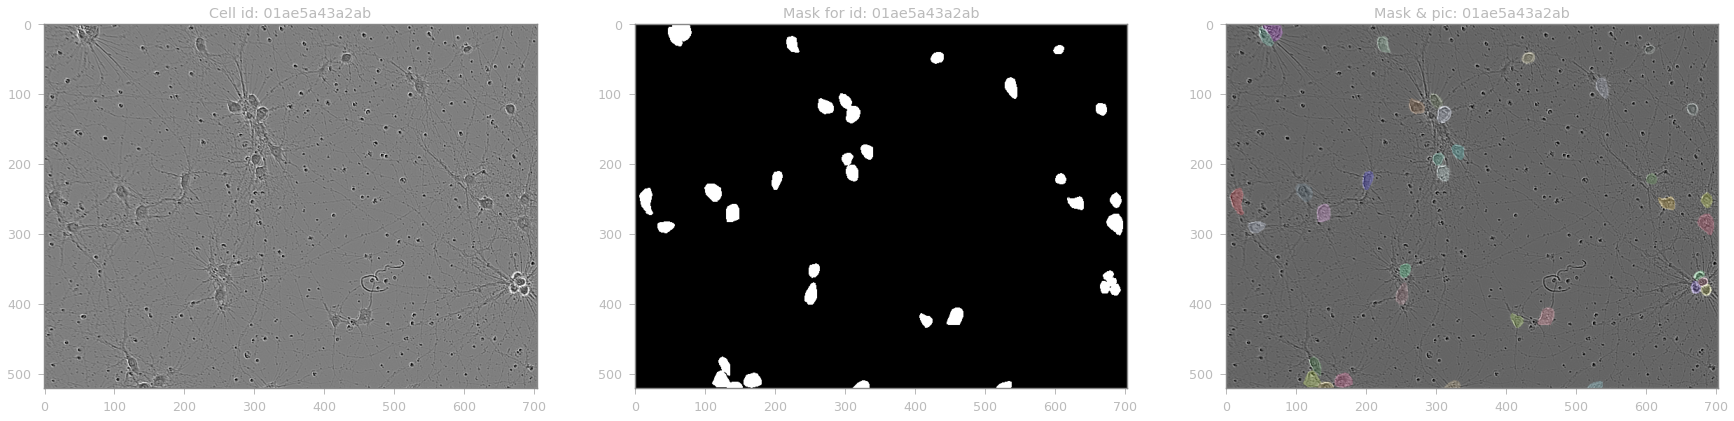

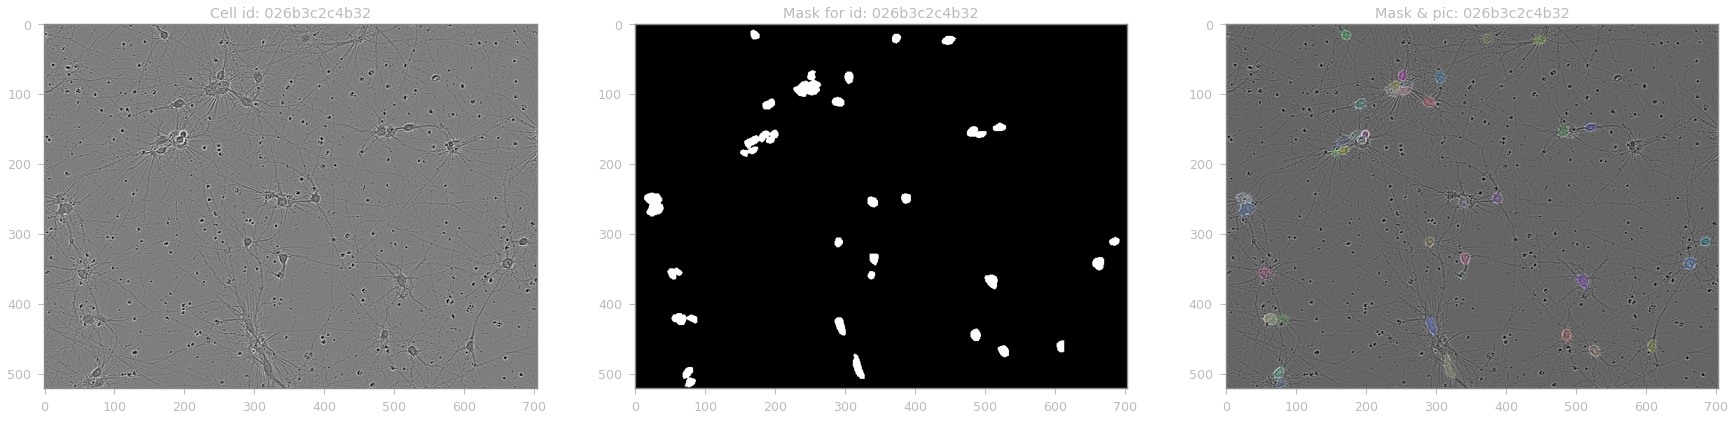

In [10]:
for i in range(4):
    #rand_idx = int(np.random.uniform(0, 607))
    #im = PIL.Image.open(train_files[rand_idx])
    im = PIL.Image.open(train_files[i])
    #label = (train_files[rand_idx]).name[:-4]
    label = (train_files[i]).stem#name[:-4]
    sample_im_df = cell_df[cell_df['id'] == label]
    sample_rles = sample_im_df['annotation'].values
    sample_masks1 = build_mask(sample_rles,input_shape=(520,704), colors=False)
    sample_masks2 = build_mask(sample_rles,input_shape=(520,704), colors=True)
    

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20),)
    ax1.imshow(im,cmap='gray')
    ax2.imshow(sample_masks1, cmap='gray')
    ax3.imshow(im,cmap='gray')
    ax3.imshow(sample_masks2,alpha = .2)
    
    ax1.set_title('Cell id: ' + str(label))
    ax2.set_title('Mask for id: ' + str(label))
    ax3.set_title('Mask & pic: ' + str(label))
    plt.show();

Let's take a closer look to the second image. Seems something wrong with a mask

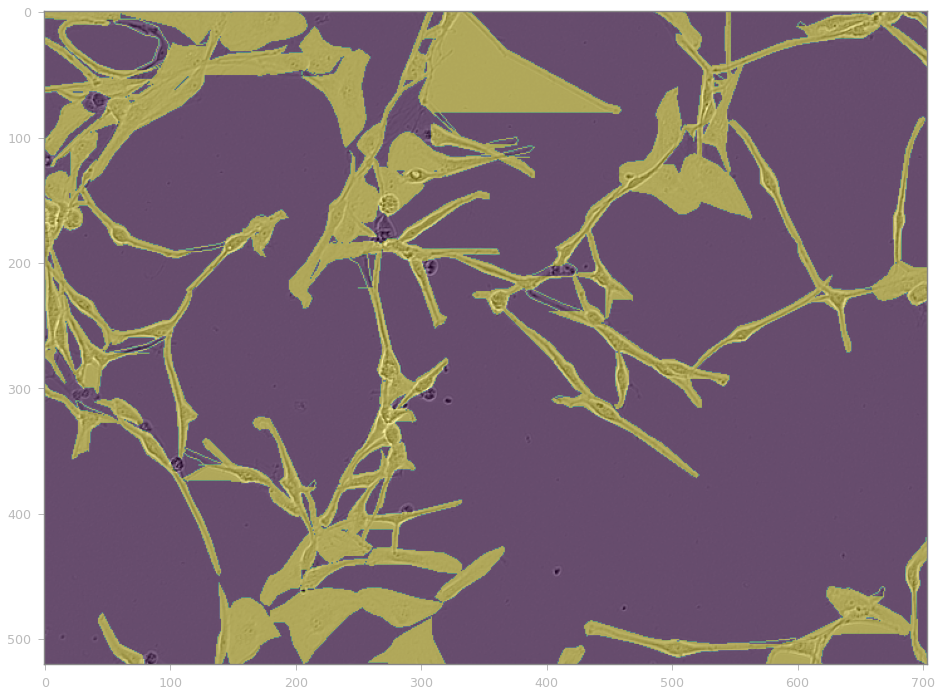

In [11]:
plt.figure(figsize=(16, 12))
im = PIL.Image.open(train_files[1])
label = (train_files[1]).stem#name[:-4]
sample_im_df = cell_df[cell_df['id'] == label]
sample_rles = sample_im_df['annotation'].values
mask = build_mask(sample_rles,input_shape=(520,704), colors=False)


plt.imshow(im,cmap='gray')
plt.imshow(mask,alpha = .4,);

Seems here we have an abnormally long continuous lines.

The mask is not representative enough.

We can take only correct masks to train our model.

**Thanks** [Slavko Prytula](https://www.kaggle.com/slavkoprytula/mask-correction-mask-filtering-updated#Utils)


In [12]:
TH = 40

def clean_mask(mask):
    '''
    Function is called to identify whether the mask is broken
    returns True or False state and also returns a mask
    '''
    mask = mask > threshold_otsu(np.array(mask).astype(np.uint8))
    mask = ndi.binary_fill_holes(mask).astype(np.uint8)
    
    # New code for mask acceptance
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c = contours[0][:, 0]
    diff = c - np.roll(c, 1, 0)
    # find horizontal lines longer than threshold
    targets = (diff[:, 1] == 0) & (np.abs(diff[:, 0]) >= TH)  
    
    return mask, (True in targets)

Re-write a function for building a masks, taking only not broken masks

In [13]:
def build_mask(labels, input_shape, colors=True):
    height, width = input_shape
    masks = np.zeros((height, width, 1))
    #masks = np.zeros((height,width), dtype=np.uint8)
    for i, label in enumerate(labels):
        a_mask = rle_decode(label, shape=(height,width, 1))
        a_mask = np.array(a_mask) > 0
        a_mask, broken_mask = clean_mask(a_mask)
        if broken_mask:
            continue
        masks += a_mask
    masks = masks.clip(0,1)
    return masks

Check the result

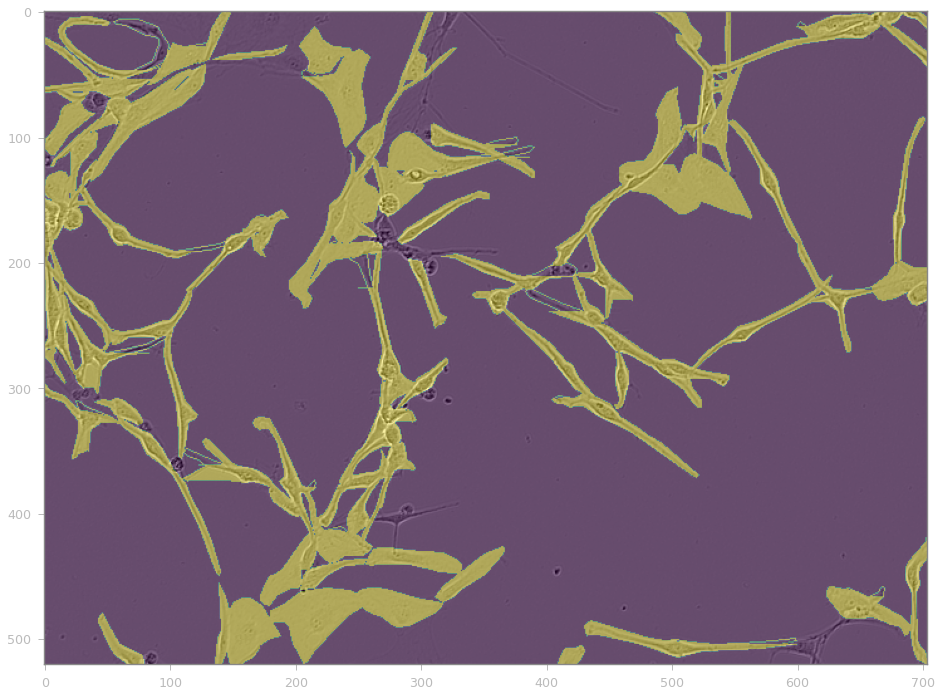

In [14]:
plt.figure(figsize=(16, 12))
mask = build_mask(sample_rles,input_shape=(520,704))

plt.imshow(im, cmap='gray')
plt.imshow(mask,alpha = .4);

# DataSets

## Define Dataset class

In [15]:
# class NeuroDataSet(Dataset):
#     def __init__(self, files, df: pd.core.frame.DataFrame, train:bool, transform=None, use_cache=False):
#         super().__init__()
#         self.files = sorted(files)
#         self.df = df
#         self.gb = self.df.groupby('id')
#         self.transform = transform
#         self.cached_img = []
#         self.cached_mask = []
#         self.use_cache = use_cache
        
        
#         self.len_ = len(self.files)
    
#     def __len__(self):
#         return self.len_
    
#     def load_sample(self, file):
#         img = cv2.imread(str(file))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img_id = file.stem
#         return img, img_id
    
#     def __getitem__(self, index):
        
#         if not self.use_cache:
#             # load image
#             image, image_id = self.load_sample(self.files[index])
#             annotation_df = self.gb.get_group(image_id)
#             #annotation = self.gb.get_group(self.files[index].stem)
#             #Create a mask
#             annotations = annotation_df['annotation'].values
#             mask = build_mask(annotations,input_shape=(520,704), colors=False)
            
#             if self.transform is not None and self.train:
#                 image = self.transform(image = image)["image"]
#                 mask = self.transform(image = mask)["image"]

#             self.cached_img.append(image)
#             self.cached_mask.append(mask)
#         else:
#             image = self.cached_img[index]
#             mask = self.cached_mask[index]
                                    
#         return image, mask
    
#     def set_use_cahe(self, use_cache):
#         if use_cache:
#             self.cached_img = torch.stack(self.cached_img)
#             self.cached_mask = torch.stack(self.cached_mask)
#         else:
#             self.cached_img = []
#             self.cached_mask = []
#         self.use_cache = use_cache

In [16]:
class NeuroDataSet(Dataset):
    def __init__(self, files, df: pd.core.frame.DataFrame, train:bool, transform=None):
        super().__init__()
        self.files = sorted(files)
        self.df = df
        self.gb = self.df.groupby('id')
        self.transform = transform      
        
        self.len_ = len(self.files)
    
    def __len__(self):
        return self.len_
    
    #@functools.lru_cache(12)
    def load_sample(self, file):
        img = cv2.imread(str(file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = np.expand_dims(img, axis=0)
        img_id = file.stem
        return img, img_id
    
    def __getitem__(self, index):
        
        # load image
        image, image_id = self.load_sample(self.files[index])
        annotation_df = self.gb.get_group(image_id)
        #annotation = self.gb.get_group(self.files[index].stem)
        #Create a mask
        annotations = annotation_df['annotation'].values
        mask = build_mask(annotations,input_shape=(520,704), colors=False)
        #mask = np.moveaxis(np.array(mask),2,0)
            
        if self.transform is not None:
            augmented = self.transform(image = image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
            #mask = self.transform(image = mask)["image"]
        
        #image = np.expand_dims(image, axis=0)
        mask = np.moveaxis(np.array(mask),2,0)
        return image,mask

## Split train-val set

In [17]:
# Split dataset to train and val sets
train_pics, val_pics = train_test_split(train_files, test_size=0.2)

In [18]:
# Extract pic Id from Path
train_pic_id = [path.stem for path in train_pics]
val_pic_id = [path.stem for path in val_pics]
# Print number of files in tran and val sets
print(f'Number of pictures in train set: {len(train_pics)}')
print()
print(f'Number of pictures in val set: {len(val_pics)}')

Number of pictures in train set: 484

Number of pictures in val set: 122


In [19]:
# split pandas dataframe with annotations for train df and val df
df_train = cell_df[(cell_df['id'].isin(train_pic_id))]
df_val = cell_df[(cell_df['id'].isin(val_pic_id))]

print(f"Number of picture's id in train set {df_train.id.nunique()}")
print()
print(f"Number of picture's id in val set {df_val.id.nunique()}")

Number of picture's id in train set 484

Number of picture's id in val set 122


## Augmentations

In [20]:
def get_augmentation(pic_size,train:bool):
    if train == False:
        augmentation_test = albumentations.Compose([A.Resize(pic_size,pic_size),
                                                    A.Normalize(
                                                        mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225]),
                                                    A.pytorch.transforms.ToTensorV2()])
        return augmentation_test
    else:
        augmentation_train = A.Compose([
            A.Resize(pic_size,pic_size),
            A.RandomCrop(pic_size, pic_size),
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.VerticalFlip(p=0.5)], p=0.5),
            A.OneOf([
                A.GaussNoise(),], p=1),
#             A.OneOf([
#                 A.MotionBlur(p=0.2),
#                 A.MedianBlur(blur_limit=3, p=0.1),
#                 A.Blur(blur_limit=3, p=0.1),], p=0.8),
#             A.ShiftScaleRotate(
#                 shift_limit=0.0625, 
#                 scale_limit=0.2, 
#                 rotate_limit=15, p=1),
            A.OneOf([
                A.OpticalDistortion(p=0.5),
                A.GridDistortion(p=0.1),], p=0.5),
#             A.OneOf([
#                 A.CLAHE(clip_limit=2),
#                 A.RandomBrightnessContrast(),], p=0.5),
#             A.HueSaturationValue(p=0.3),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
            A.pytorch.transforms.ToTensorV2()], p=1)
        return augmentation_train


## Data Loaders

In [21]:
BATCH_SIZE = 4

In [22]:
train_dataset = NeuroDataSet(train_pics,
                             df_train,train=True,
                             transform=get_augmentation(224, train=True)
                            )

In [23]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=4,) # pc -8 lap =4

In [24]:
val_dataset = NeuroDataSet(val_pics,
                           df_val,
                           train=False,
                          transform=get_augmentation(224, train=False))

In [25]:
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=4) # pc -8 lap =4

In [26]:
batch = next(iter(train_loader))
images, masks = batch
print(f"image shape: {images.shape},\nmask shape:{masks.shape},\nbatch len: {len(batch)}")
del batch

image shape: torch.Size([4, 3, 224, 224]),
mask shape:torch.Size([4, 1, 224, 224]),
batch len: 2


## Visualize Augmented DataSet

In [27]:
import copy

In [28]:
def visualize_augmentations(dataset, idx=1, samples=6, cols=3):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, A.pytorch.ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))
    for i in range(samples):
        image, mask = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    del dataset

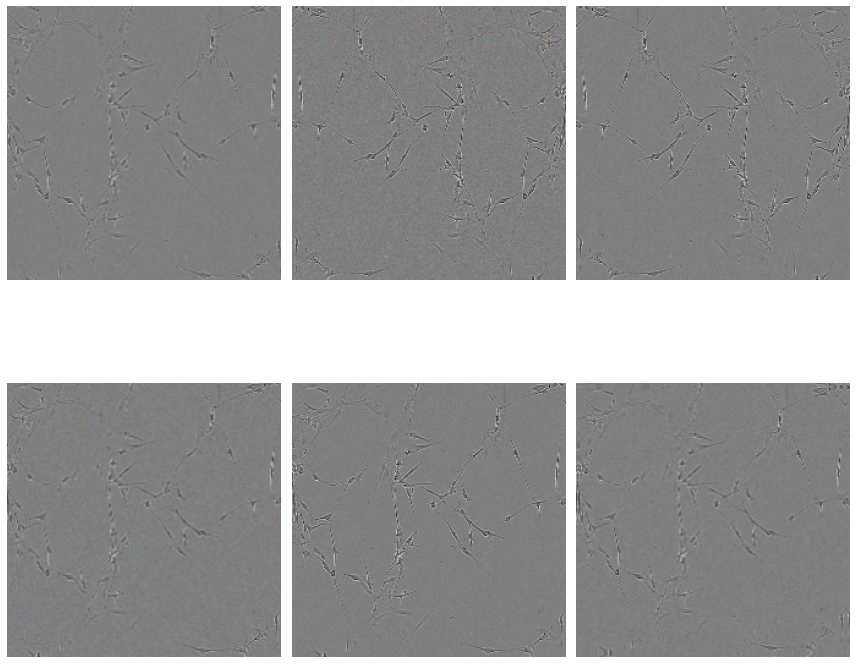

In [29]:
visualize_augmentations(train_dataset,idx=1)

# Unet-baseline

In [30]:
# Create convolution block class
class Conv_Block(nn.Module):
    '''convolution ==> BN ==> ReLU'''
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [31]:
# enc_block = Conv_Block(3, 64)
# x = torch.randn(16,3,224,224)
# enc_block(x).shape

In [32]:
class Encoder(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            Conv_Block(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [33]:
# encoder = Encoder(3,128)
# # input image
# x    = torch.randn(1, 3, 244, 244)
# encoder(x).shape

In [34]:
class Decoder(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = Conv_Block(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
#         # input CxHxW
#         diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
#         diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        
#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [35]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [36]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = Conv_Block(n_channels, 64)
        self.enc1 = Encoder(64, 128)
        self.enc2 = Encoder(128, 256)
        self.enc3 = Encoder(256, 512)
        self.enc4 = Encoder(512, 512)
        self.dec1 = Decoder(1024, 256, bilinear)
        self.dec2 = Decoder(512, 128, bilinear)
        self.dec3 = Decoder(256, 64, bilinear)
        self.dec4 = Decoder(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x = self.dec1(x5, x4)
        x = self.dec2(x, x3)
        x = self.dec3(x, x2)
        x = self.dec4(x, x1)
        logits = self.outc(x)
        return logits

## Train

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [80]:
print(f"Initial GPU Usage at fit_epoch")
gpu_usage()

Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 |  1% | 39% |


In [39]:
def train_loop(model, optimizer, criterion, train_loader, device=device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    
#     print(f"Initial GPU Usage at fit_epoch")
#     gpu_usage()
    
    for imgs, masks in pbar:
        optimizer.zero_grad()
        imgs=imgs.to(device).float()
        masks = masks.to(device).float()
        # forward
        
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0]
        
        loss.backward()
#         print(f"In loop before del")
#         gpu_usage()
        del imgs, masks
#         print(f"Afteer deletion in loop")
#         gpu_usage()
        torch.cuda.empty_cache()
        
    running_loss /= len(train_loader.sampler)
    print('Train_loss: %f' % running_loss)
    torch.cuda.empty_cache()
    #print(f"Afteer deletion")
    #gpu_usage()
    return running_loss

In [40]:
from IPython.display import clear_output

In [41]:
def eval_loop(model, criterion, val_loader, device=device):
    running_loss=0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        pbar = tqdm(val_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            imgs = imgs.to(device).float()
            masks = masks.to(device).float()
            # forward
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            
            y_hat = (out > 0.5).float()
            y_hat = y_hat.view(-1).detach().cpu().numpy()
            labels = masks.view(-1).detach().cpu().numpy()
            accuracy.append(accuracy_score(labels, y_hat))
            f1_scores.append(f1_score(labels, y_hat))
            
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(val_loader.sampler)
    print('Val_loss: %f' % running_loss)
    del imgs, masks, y_hat, labels
    torch.cuda.empty_cache()
    
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss}

In [42]:
def visualize_train(model,val_loader, device=device):
    model.eval()
    X_val, Y_val = next(iter(val_loader))
    Y_hat = model(X_val.to(device))
    Y_hat = Y_hat.detach().cpu().numpy()
    
    clear_output(wait=True)
    for k in range(2):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),)
        ax1.imshow(np.rollaxis(X_val[k].numpy(), 0, 3),cmap='gray')
        #ax2.imshow(((Y_hat[k, 0] * 255)).astype('uint8'), cmap='gray')
        ax2.imshow(((Y_hat[k, 0] * 255)), cmap='gray')
        ax1.set_axis_off()
        ax2.set_axis_off()
        ax1.set_title('Real')
        ax2.set_title('Output')
    #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()
    del X_val, Y_hat

In [43]:
def train(model,optimizer,criterion,
          train_loader,val_loader,
          device=device,epochs=5,
          valid_loss_min=np.inf,vis=True):
    writer = SummaryWriter(comment=f'BS_{train_loader.batch_size}_Epchs_{epochs}')
    history = []
    
    
    for epoch in range(epochs):
        train_loss = train_loop(model,optimizer,criterion,train_loader,device=device)
        # evaluate on validation set
        metrics = eval_loop(model,criterion,val_loader,device=device)
        history.append((train_loss,metrics["loss"],metrics["accuracy"]))
        
        if vis:
            visualize_train(model,val_loader,device=device)
        
        # show progress
        print_string = f'Epoch: {epoch+1} '
        print_string+= f'TrainLoss from train func: {train_loss:.5f} '
        print_string+= f'ValidLoss from train func: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print(print_string)
    
    return history
    

In [44]:
model = UNet(3,1)
model = model.to(device)

In [45]:
# import segmentation_models_pytorch as smp
# ENCODER          = 'se_resnext50_32x4d'
# ENCODER_WEIGHTS  = 'imagenet'
# CLASSES          = ['mask']
# ACTIVATION       = None

In [46]:
# model = smp.Unet(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=len(CLASSES), 
#     activation=ACTIVATION,
# )
# model = model.to(device)

In [47]:
# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [48]:
def bce_loss(y_real, y_pred):
    # .clamp эквивалентоно Relu
    loss = (y_pred.clamp(min=0) - y_pred * y_real + (1 + (-y_pred.abs()).exp()).log()).mean()
    return loss

In [49]:
max_epochs = 5
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

In [50]:
history = train(model,optim,dice_loss,train_loader,val_loader,epochs=max_epochs, vis=False)

Iterating over train data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [06:23<00:00,  3.17s/it]


Train_loss: 0.170042


Iterating over evaluation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:35<00:00,  3.07s/it]


Val_loss: 0.174123
Epoch: 1 TrainLoss from train func: 0.17004 ValidLoss from train func: 0.17412 ACC: 0.82922 F1: 0.223


Iterating over train data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [06:30<00:00,  3.23s/it]


Train_loss: 0.170143


Iterating over evaluation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:39<00:00,  3.20s/it]


Val_loss: 0.174030
Epoch: 2 TrainLoss from train func: 0.17014 ValidLoss from train func: 0.17403 ACC: 0.82893 F1: 0.222


Iterating over train data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [06:32<00:00,  3.25s/it]


Train_loss: 0.170354


Iterating over evaluation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:32<00:00,  2.98s/it]


Val_loss: 0.173543
Epoch: 3 TrainLoss from train func: 0.17035 ValidLoss from train func: 0.17354 ACC: 0.83499 F1: 0.218


Iterating over train data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [06:13<00:00,  3.08s/it]


Train_loss: 0.170416


Iterating over evaluation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:31<00:00,  2.94s/it]


Val_loss: 0.173164
Epoch: 4 TrainLoss from train func: 0.17042 ValidLoss from train func: 0.17316 ACC: 0.84021 F1: 0.215


Iterating over train data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [06:12<00:00,  3.08s/it]


Train_loss: 0.169903


Iterating over evaluation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:29<00:00,  2.90s/it]

Val_loss: 0.174023
Epoch: 5 TrainLoss from train func: 0.16990 ValidLoss from train func: 0.17402 ACC: 0.82893 F1: 0.222


## Evaluating

In [78]:
def plot_loss_acc(history):
    """Print Loss in train and val sets"""
    train_loss, val_loss, acc = zip(*history)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
    fig.suptitle('Loss and Accuracy')
    ax1.plot(train_loss, label="train_loss")
    ax1.plot(val_loss, label="val_loss")
    ax1.legend(loc='best')
    plt.ylabel("loss")

    #ax2.plot(acc, label="train_accuracy")
    ax2.plot(val_acc, label="val_accuracy")
    ax2.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

In [52]:
train_loss, val_loss, val_acc = zip(*history)

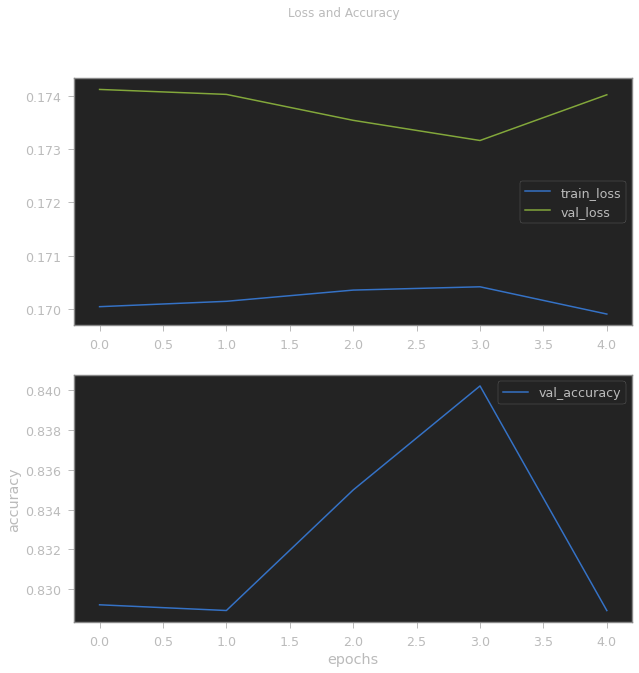

In [53]:
plot_loss_acc(history)

In [56]:
# PyTroch version

SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [57]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        Y_label = Y_label.byte()
        scores += metric(Y_pred>0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

In [58]:
score_model(model, iou_pytorch, val_loader)

0.0

# Unet from Segmentation Models

https://github.com/qubvel/segmentation_models.pytorch#installation

In [67]:
import segmentation_models_pytorch as smp
from Losses import ComboLoss, dice_metric

In [70]:
ENCODER          = 'se_resnext50_32x4d'
ENCODER_WEIGHTS  = 'imagenet'
CLASSES          = ['mask']
ACTIVATION       = None
CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})

In [60]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [61]:
# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [62]:
# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [65]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /home/paul/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [68]:
model = model.to(device)

In [69]:
max_epochs = 5
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

In [71]:
history = train(model,optim,CRITERION,train_loader,val_loader,epochs=max_epochs, vis=False)

Iterating over train data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [06:24<00:00,  3.18s/it]


Train_loss: 4.419230


Iterating over evaluation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:31<00:00,  2.96s/it]


Val_loss: 4.230557
Epoch: 1 TrainLoss from train func: 4.41923 ValidLoss from train func: 4.23056 ACC: 0.74844 F1: 0.221


Iterating over train data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [06:22<00:00,  3.16s/it]


Train_loss: 4.419838


Iterating over evaluation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:39<00:00,  3.21s/it]


Val_loss: 4.196798
Epoch: 2 TrainLoss from train func: 4.41984 ValidLoss from train func: 4.19680 ACC: 0.75195 F1: 0.220


Iterating over train data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [06:17<00:00,  3.12s/it]


Train_loss: 4.419446


Iterating over evaluation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:35<00:00,  3.07s/it]


Val_loss: 4.197585
Epoch: 3 TrainLoss from train func: 4.41945 ValidLoss from train func: 4.19758 ACC: 0.75176 F1: 0.220


Iterating over train data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [06:41<00:00,  3.31s/it]


Train_loss: 4.420462


Iterating over evaluation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:42<00:00,  3.30s/it]


Val_loss: 4.203651
Epoch: 4 TrainLoss from train func: 4.42046 ValidLoss from train func: 4.20365 ACC: 0.75093 F1: 0.221


Iterating over train data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [06:39<00:00,  3.30s/it]


Train_loss: 4.416947


Iterating over evaluation data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:40<00:00,  3.24s/it]

Val_loss: 4.213866
Epoch: 5 TrainLoss from train func: 4.41695 ValidLoss from train func: 4.21387 ACC: 0.74972 F1: 0.221


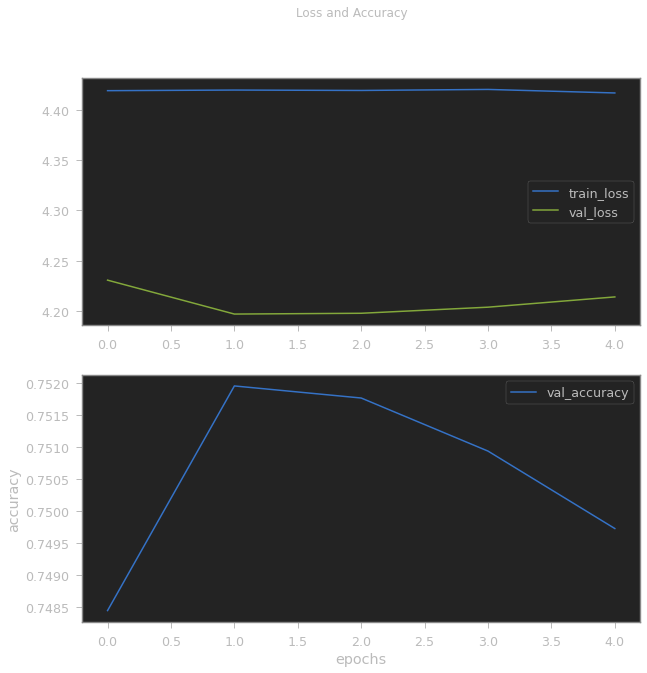

In [79]:
plot_loss_acc(history)

In [75]:
history

[(4.41923030742929, 4.230557441711426, 0.7484422574473338),
 (4.419838008801799, 4.196797972819844, 0.7519481425382653),
 (4.4194464250044385, 4.197584941738942, 0.7517596126152071),
 (4.420462383711634, 4.203650591803378, 0.7509312381706715),
 (4.416947404215159, 4.213866491786769, 0.749722589388578)]

In [ ]:
0s

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
ENCODER          = 'se_resnext50_32x4d'
ENCODER_WEIGHTS  = 'imagenet'
CLASSES          = ['mask']
ACTIVATION       = None

In [ ]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
from IPython.display import clear_output

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:

          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)
          opt.zero_grad()
           
          Y_pred = model(X_batch)
          loss = loss_fn(Y_batch, Y_pred)
          loss.backward()  # backward-pass
          opt.step()   # update weights
          torch.cuda.empty_cache()

            # calculate loss to show the user
          avg_loss += loss / len(data_tr)
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device))
        # detach and put into cpu
        Y_hat = Y_hat.detach().cpu().numpy()

        # Visualize tools
        clear_output(wait=True)
        torch.cuda.empty_cache()
        for k in range(6):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 20),)
            plt.subplot(2, 6, k+1, )#figsize=(15, 15))
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7,)#figsize=(15, 15))
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred>0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:
model = UNet(3,1)
model = model.to(device)

In [ ]:
max_epochs = 5
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optim, dice_loss, max_epochs, train_loader, val_loader)

In [ ]:
score_model(model, iou_pytorch, val_loader)